In [1]:
import pandas as pd
import numpy as np
import imblearn
import sklearn

df= pd.read_csv('churn.csv', sep=',')

df.head()

,Customer_ID,Gender,Age,Marital_status,Children,Tenure_months,Monthly_charges,Total_charges,Phone,Internet,Contract,Paperless_billing,Payment_method,Churn
0,1,Female,50,1.0,NaN,8,94.20,777.3,Yes,Fiber,Monthly,Yes,Electronic check,Yes
1,2,Male,70,1.0,NaN,24,78.85,1772.25,Yes,Fiber,Monthly,Yes,Electronic check,Yes
2,3,Male,73,NaN,NaN,47,20.05,951.55,Yes,No,Yearly,No,Mailed check,No
3,4,Male,37,NaN,NaN,17,93.85,1625.65,Yes,Fiber,Monthly,No,Electronic check,Yes
4,5,Female,71,NaN,1.0,32,79.50,2665,Yes,Fiber,Monthly,Yes,Electronic check,No


In [2]:
df = df.drop('Customer_ID', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Age                7043 non-null   int64  
 2   Marital_status     3889 non-null   float64
 3   Children           3903 non-null   float64
 4   Tenure_months      7043 non-null   int64  
 5   Monthly_charges    7043 non-null   float64
 6   Total_charges      7043 non-null   object 
 7   Phone              7043 non-null   object 
 8   Internet           7043 non-null   object 
 9   Contract           7043 non-null   object 
 10  Paperless_billing  7043 non-null   object 
 11  Payment_method     7043 non-null   object 
 12  Churn              7043 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 715.4+ KB


<AxesSubplot:title={'center':'Count (churn)'}>

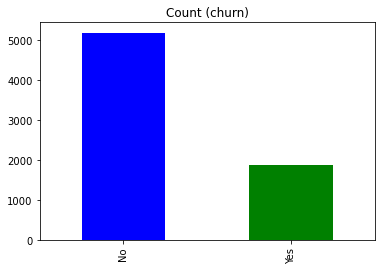

In [5]:

df.Churn.value_counts().plot(kind='bar', title='Count (churn)', color = ['b', 'g'])

In [ ]:
# We see that the data is imbalanced, we have almost 3 times more non-churners than those who churn

<AxesSubplot:title={'center':'Count (by gender)'}>

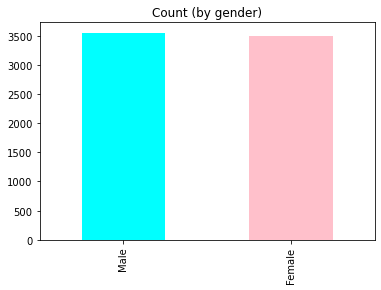

In [8]:

df.Gender.value_counts().plot(kind='bar', title='Count (by gender)', color = ['cyan', 'pink'])

<AxesSubplot:title={'center':'Count (by phone)'}>

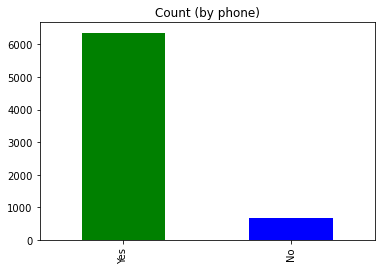

In [11]:

df.Phone.value_counts().plot(kind='bar', title='Count (by phone)', color = ['g', 'b'])

<AxesSubplot:title={'center':'Count (by payment method)'}>

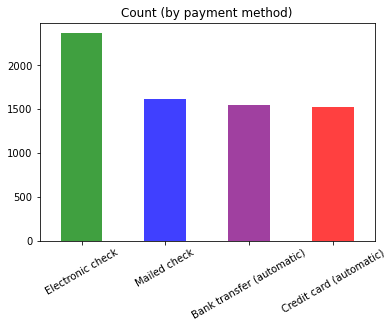

In [23]:

df.Payment_method.value_counts().plot(rot=30, alpha=0.75, kind='bar', title='Count (by payment method)', color = ['g', 'b', 'purple', 'red'])

In [24]:
df.describe()

,Age,Marital_status,Children,Tenure_months,Monthly_charges
count,7043.000000,3889.000000,3903.000000,7043.000000,7043.000000
mean,50.503337,0.601183,0.584935,32.371149,64.761692
std,17.300733,0.489718,0.492796,24.559481,30.090047
min,21.000000,0.000000,0.000000,0.000000,18.250000
25%,36.000000,0.000000,0.000000,9.000000,35.500000
50%,50.000000,1.000000,1.000000,29.000000,70.350000
75%,66.000000,1.000000,1.000000,55.000000,89.850000
max,80.000000,1.000000,1.000000,72.000000,118.750000


Text(12.133611111111122, 0.5, 'Monthly charges')

<Figure size 1440x1440 with 0 Axes>

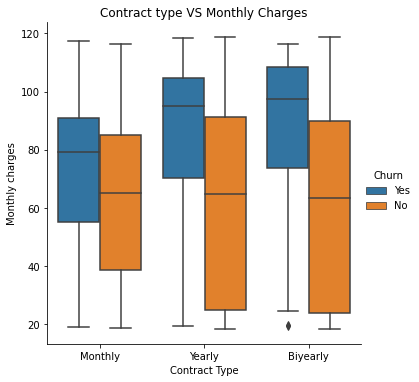

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Looking at Contract type and Churn against Monthly charges
plt.figure(figsize=(20,20))
sns.catplot(x="Contract", y="Monthly_charges", hue="Churn", kind="box", data=df)
plt.title("Contract type VS Monthly Charges")
plt.xlabel("Contract Type")
plt.ylabel("Monthly charges")

<AxesSubplot:xlabel='Monthly_charges', ylabel='Count'>

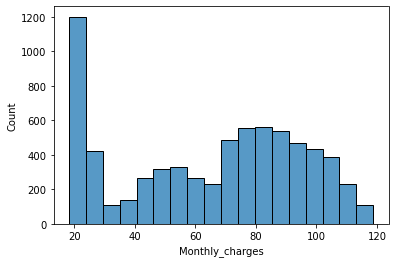

In [6]:

sns.histplot(data=df, x="Monthly_charges")

In [7]:
# checking for highly correlated variables
correlations = df.corr()
correlations

,Age,Marital_status,Children,Tenure_months,Monthly_charges
Age,1.000000,0.015602,-0.007701,-0.007732,-0.005719
Marital_status,0.015602,1.000000,0.002243,-0.016284,-0.021018
Children,-0.007701,0.002243,1.000000,-0.002200,-0.004108
Tenure_months,-0.007732,-0.016284,-0.002200,1.000000,0.247900
Monthly_charges,-0.005719,-0.021018,-0.004108,0.247900,1.000000


We see that no variables except Monthly_charges vs Tenure_months have high correlation, but it's
quite understandable in the context, so let's leave like this

# Churn binary classification

## Pre-processing data

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline


#lists of same datatype columns
to_cat = ['Gender','Marital_status', 'Children', 'Phone', 'Internet', 'Paperless_billing', 'Contract', 'Payment_method']
to_scale = ['Age', 'Tenure_months', 'Monthly_charges', 'Total_charges']

encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

scale_pipe = make_pipeline(MinMaxScaler())
categorical_pipe = make_pipeline(encoder)



transformer = ColumnTransformer(
    transformers=[
        ("scale", scale_pipe, to_scale),
        ("categorical", categorical_pipe, to_cat)        
    ], remainder='passthrough'
)


df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Total_charges'] = df['Total_charges'].map({'': 0})
df['Total_charges'] = df['Total_charges'].astype(float)

X = df.loc[:, df.columns!='Churn']
y = df['Churn']



In [9]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train

,Gender,Age,Marital_status,Children,Tenure_months,Monthly_charges,Total_charges,Phone,Internet,Contract,Paperless_billing,Payment_method
1695,Male,35,0.0,NaN,20,96.80,NaN,Yes,Fiber,Monthly,No,Mailed check
1095,Female,72,1.0,0.0,26,84.95,NaN,Yes,Fiber,Monthly,No,Electronic check
3889,Female,62,0.0,1.0,1,94.40,NaN,Yes,Fiber,Monthly,No,Electronic check
3667,Male,63,1.0,1.0,53,60.45,NaN,No,DSL,Yearly,Yes,Electronic check
2902,Female,75,1.0,1.0,56,104.75,NaN,Yes,Fiber,Monthly,No,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...
3772,Male,26,1.0,NaN,72,20.30,NaN,Yes,No,Biyearly,No,Bank transfer (automatic)
5191,Male,27,1.0,1.0,46,30.75,NaN,No,DSL,Yearly,Yes,Bank transfer (automatic)
5226,Male,74,0.0,NaN,25,55.55,NaN,Yes,DSL,Monthly,No,Credit card (automatic)
5390,Female,61,0.0,1.0,12,94.20,NaN,Yes,Fiber,Monthly,Yes,Electronic check


In [13]:
OHE1 = encoder.fit_transform(df[to_cat[0]].values.reshape(-1,1))
columns1 = ["Gender_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]
OHE2 = encoder.fit_transform(df[to_cat[1]].values.reshape(-1,1))
columns2 = ["Marital_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]


In [14]:
columns1

['Gender_Female', 'Gender_Male']

In [15]:
columns2

['Marital_0.0', 'Marital_1.0', 'Marital_nan']

In [16]:
OHE3 = encoder.fit_transform(df[to_cat[2]].values.reshape(-1,1))
columns3 = ["Children_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]
OHE4 = encoder.fit_transform(df[to_cat[3]].values.reshape(-1,1))
columns4 = ["Phone_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]
OHE5 = encoder.fit_transform(df[to_cat[4]].values.reshape(-1,1))
columns5 = ["Internet_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]
OHE6 = encoder.fit_transform(df[to_cat[5]].values.reshape(-1,1))
columns6 = ["Paperless_billing_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]

OHE7 = encoder.fit_transform(df[to_cat[6]].values.reshape(-1,1))
columns7 = ["Contract_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]
OHE8 = encoder.fit_transform(df[to_cat[7]].values.reshape(-1,1))
columns8 = ["Payment_method_" + str(encoder.categories_[0][i]) 
                                     for i in range(len(encoder.categories_[0]))]

In [17]:
cnames = to_scale  + columns1+columns2+columns3+columns4+columns5+columns6+columns7+columns8

In [18]:
X_transformed= pd.DataFrame(transformer.fit_transform(X_train), columns=cnames)
X_transformed

/Users/zarina/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/zarina/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,Age,Tenure_months,Monthly_charges,Total_charges,Gender_Female,Gender_Male,Marital_0.0,Marital_1.0,Marital_nan,Children_0.0,...,Internet_No,Paperless_billing_No,Paperless_billing_Yes,Contract_Biyearly,Contract_Monthly,Contract_Yearly,Payment_method_Bank transfer (automatic),Payment_method_Credit card (automatic),Payment_method_Electronic check,Payment_method_Mailed check
0,0.237288,0.277778,0.781592,NaN,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.864407,0.361111,0.663682,NaN,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.694915,0.013889,0.757711,NaN,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.711864,0.736111,0.419900,NaN,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.915254,0.777778,0.860697,NaN,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925,0.084746,1.000000,0.020398,NaN,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4926,0.101695,0.638889,0.124378,NaN,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4927,0.898305,0.347222,0.371144,NaN,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4928,0.677966,0.166667,0.755721,NaN,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Data imputation using knn

In [20]:
from sklearn.impute import KNNImputer



imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(X_transformed)
X_transformed = imputer.transform(X_transformed)

In EDA, we have seen the data is largely imbalanced, therefore let's OVERSAMPLE minor class with SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_transformed, y_train)

In [22]:
X_resampled.shape

(7234, 25)

# Building a model & Feature Selection¶


## Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

#since the're too many input features (28), I use PCA to reduce the dimensionality
# Later I apply Random Forest Classifier and also tune hyperparametres using gridsearch to obtain the best result
# P.S. To save time, I passed little number of parameters


params2 = { 'max_depth': [5,15],
           'min_samples_split': [2, 10],
           'n_estimators': [100, 500],
           'min_samples_leaf': [5]}

forest = RandomForestClassifier(max_depth=6, random_state=42)

forest1 = GridSearchCV(forest, param_grid=params2, verbose = 1, cv=3, n_jobs = -1)

steps1 = [('pca',  PCA(n_components = 0.95)), ('m1', forest1)]
model1 = Pipeline(steps=steps1)




## XGB Classifier

In [26]:
from xgboost import XGBClassifier


# Model 2: I apply XGBoost classifier and also tune hyperparametres using gridsearch to obtain the best result
# P.S. To save time, I passed little number of parameters

params = { 'max_depth': [3,6],
           'learning_rate': [0.05, 0.1],
           'n_estimators': [100, 500],
           'colsample_bytree': [0.7]}

xgb = XGBClassifier()
clf1 = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   verbose=1)




steps2 = [('pca', PCA(n_components = 0.95)), ('m2', clf1)]
model2 = Pipeline(steps=steps2)

In [27]:
from sklearn.naive_bayes import GaussianNB

params_NB = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

#hyperparameter tuning
nb_classifier = GridSearchCV(estimator=GaussianNB(), param_grid=params_NB, verbose=1, cv=10, n_jobs=-1)


## Model evaluation

In [34]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



model1.fit(X_transformed, y_train)
y_pred = model1.predict(imputer.transform(pd.DataFrame(transformer.fit_transform(X_test), columns=cnames)))

# evaluate model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/zarina/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/zarina/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1557
           1       0.66      0.42      0.51       556

    accuracy                           0.79      2113
   macro avg       0.74      0.67      0.69      2113
weighted avg       0.78      0.79      0.77      2113



In [35]:
model2.fit(X_transformed, y_train)
y_pred2 = model2.predict(imputer.transform(pd.DataFrame(transformer.fit_transform(X_test), columns=cnames)))

print(classification_report(y_test, y_pred2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[22:16:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zarina/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/zarina/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1557
           1       0.62      0.47      0.53       556

    accuracy                           0.79      2113
   macro avg       0.72      0.68      0.70      2113
weighted avg       0.77      0.79      0.77      2113



In [32]:
nb_classifier.fit(X_resampled, y_resampled)

print(nb_classifier.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'var_smoothing': 0.08111308307896872}


In [33]:
y_pred_nb  =  nb_classifier.predict(imputer.transform(pd.DataFrame(transformer.transform(X_test), columns=cnames)))

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1557
           1       0.47      0.77      0.58       556

    accuracy                           0.71      2113
   macro avg       0.68      0.73      0.68      2113
weighted avg       0.78      0.71      0.72      2113



We see that for some of the classifiers (naive bayes in this case) the results are pretty good for some classes (e.g. churn=0)although they perform poor on prediction of churn=1. 

Here one should take into consideration whether it's more important for the company to predict right those who churn, or those who don't. This decision should be made taking into account
expenses on the measures who are predicted to churn, amount of customers whom we predict to churn, etc.

Once again, several performance metrics are available, so it is important to choose the right metrics based on our goals and context
